# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.3 MB/s eta 0:00:00


Импорт необходимых библиотек

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import random

import seaborn
seaborn.set(palette='summer')

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [7]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

### Здесь я заменил порог на минимальное количество вхождений одного слова counter_threshold с 25 на 10, вроде бы обучение от этого не сильно удлиняется, а результат может улучшиться.  Также заменил пунктуацию на пробелы (кажется так будет лучше для слов через "-" или "/", но без пробелов перед этими знаками)

In [8]:
words = Counter()
# lemmas = Counter()
proccessed_text_test_list = [] # взглянем на предложения после процессинга, но до токенизации

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    # Заменим пунктуацию на пробелы (кажется так будет лучше для слов через "-" или "/", но без пробелов перед этими знаками)
    prccessed_text = example.lower().translate(
        str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    proccessed_text_test_list.append(prccessed_text)

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
# counter_threshold = 25
counter_threshold = 10

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 18641


### Рандомное предложение до и после предобработки:

In [24]:
index = random.randint(0, 1000)
# index = 612
print(f'index = {index}')
print(len(dataset['train'][index]['text']))
print(dataset['train'][index]['text'])
print(len(proccessed_text_test_list[index]))
print(proccessed_text_test_list[index])

index = 921
100
A Stereo with a Brain You can train Bose's new system to play songs you like. Is it worth the price?
100
a stereo with a brain you can train bose s new system to play songs you like  is it worth the price 


In [11]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
        str.maketrans(string.punctuation, ' '*len(string.punctuation)))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [12]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

### Здесь я дополнительно сделал тестовый датасет для финальной проверки перфоманса моделей

In [13]:
test_idx = list(set(np.arange(len(dataset['test']))) - set(idx))
test_dataset = WordDataset(dataset['test'].select(test_idx))
test_dataloader = DataLoader(
    test_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

### Рандомное предложение до и после токенизации:

In [15]:
print(len(dataset['train'][index]['text']))
print(dataset['train'][index]['text'])
print(len(proccessed_text_test_list[index]))
print((proccessed_text_test_list[index]))
print(len(train_dataset[index]['text']))
print(list(map(ind2word.get, train_dataset[index]['text'])))

256
Charley's Force Took Experts by Surprise (AP) AP - Hurricane Charley's 145-mph force took forecasters by surprise and showed just how shaky a science it still is to predict a storm's intensity  #151; even with all the latest satellite and radar technology.
256
charley s force took experts by surprise  ap  ap   hurricane charley s 145 mph force took forecasters by surprise and showed just how shaky a science it still is to predict a storm s intensity   151  even with all the latest satellite and radar technology 
47
['<bos>', 'charley', 's', 'force', 'took', 'experts', 'by', 'surprise', 'ap', 'ap', 'hurricane', 'charley', 's', '145', 'mph', 'force', 'took', 'forecasters', 'by', 'surprise', 'and', 'showed', 'just', 'how', 'shaky', 'a', 'science', 'it', 'still', 'is', 'to', 'predict', 'a', 'storm', 's', 'intensity', '151', 'even', 'with', 'all', 'the', 'latest', 'satellite', 'and', 'radar', 'technology', '<eos>']


## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [16]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

# --------------------------------- Baseline CharLM model ----------------------------

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, embeding_len: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embeding_len)
        self.rnn = nn.RNN(embeding_len, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, embeding_len]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

model_max = CharLM(hidden_dim=256, vocab_size=len(vocab), embeding_len=256, aggregation_type='max').to(device)
model_mean = CharLM(hidden_dim=256, vocab_size=len(vocab), embeding_len=256, aggregation_type='mean').to(device)

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), embeding_len=256, aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

    if aggregation_type == 'max':
        model_max = model
    else:
        model_mean = model

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

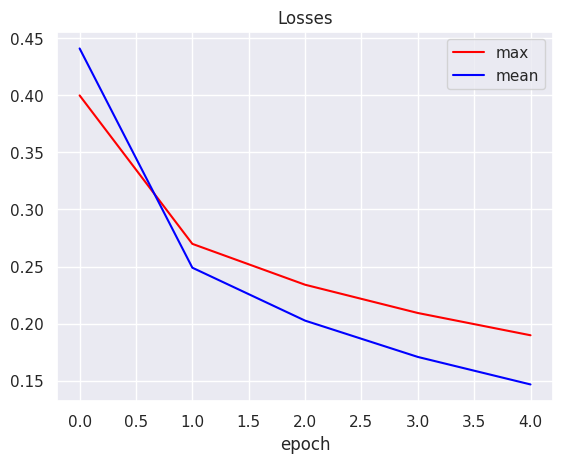

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 90.90
Лучшая accuracy для подхода mean: 91.08


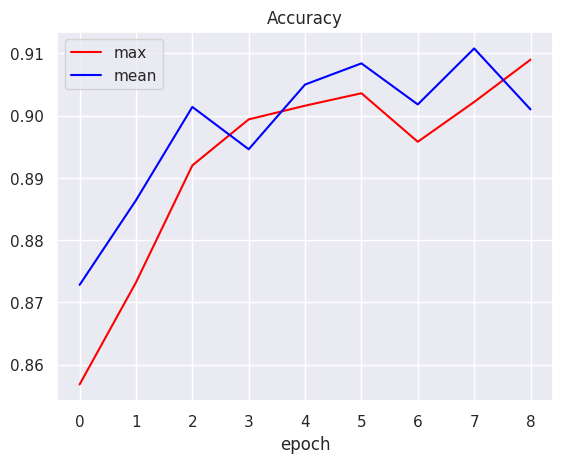

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
test_predictions = []
test_target = []
with torch.no_grad():
    for batch in test_dataloader:
        model_max.eval()
        logits = model_max(batch['input_ids'])
        test_predictions.append(logits.argmax(dim=1))
        test_target.append(batch['label'])
test_predictions = torch.cat(test_predictions)
test_target = torch.cat(test_target)
test_accuracy_max = (test_predictions == test_target).float().mean().item()

print(f'test_accuracy_max = {np.around(test_accuracy_max, 3)}')

test_accuracy_max = 0.909


In [ ]:
test_predictions = []
test_target = []
with torch.no_grad():
    for batch in test_dataloader:
        model_mean.eval()
        logits = model_mean(batch['input_ids'])
        test_predictions.append(logits.argmax(dim=1))
        test_target.append(batch['label'])
test_predictions = torch.cat(test_predictions)
test_target = torch.cat(test_target)
test_accuracy_mean = (test_predictions == test_target).float().mean().item()

print(f'test_accuracy_mean = {np.around(test_accuracy_mean, 3)}')

test_accuracy_mean = 0.913


# -------------------------- Experiments ---------------------------------

## --------------------------------------- GRU -----------------------------------------

In [ ]:
class CharLM_GRU(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, embeding_len: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embeding_len)
        self.rnn = nn.GRU(embeding_len, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type_GRU = {}
acc_type_GRU = {}

model_GRU_max = CharLM_GRU(hidden_dim=256, vocab_size=len(vocab), embeding_len=256, aggregation_type='max').to(device)
model_GRU_mean = CharLM_GRU(hidden_dim=256, vocab_size=len(vocab), embeding_len=256, aggregation_type='mean').to(device)

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_GRU = CharLM_GRU(
        hidden_dim=256, vocab_size=len(vocab), embeding_len=256, aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_GRU.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_GRU.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_GRU(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_GRU.eval()
                acc.append(evaluate(model_GRU, eval_dataloader))
                model_GRU.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_GRU[aggregation_type] = losses
    acc_type_GRU[aggregation_type] = acc

    if aggregation_type == 'max':
        model_GRU_max = model_GRU
    else:
        model_GRU_mean = model_GRU

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

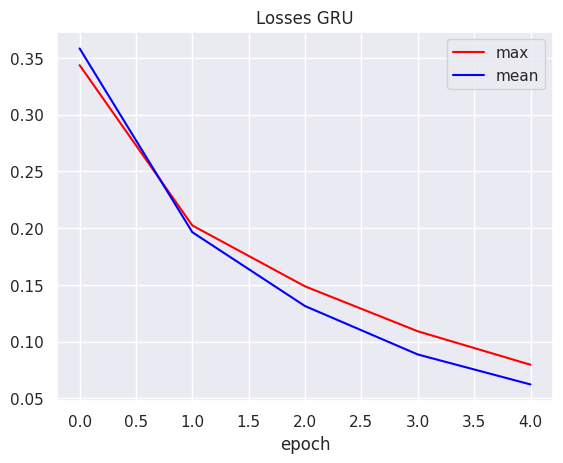

In [ ]:
for (name, values), color in zip(losses_type_GRU.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_GRU[name])), losses_type_GRU[name], color=color, label=name)

plt.title('Losses GRU')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 92.00
Лучшая accuracy для подхода mean: 91.88


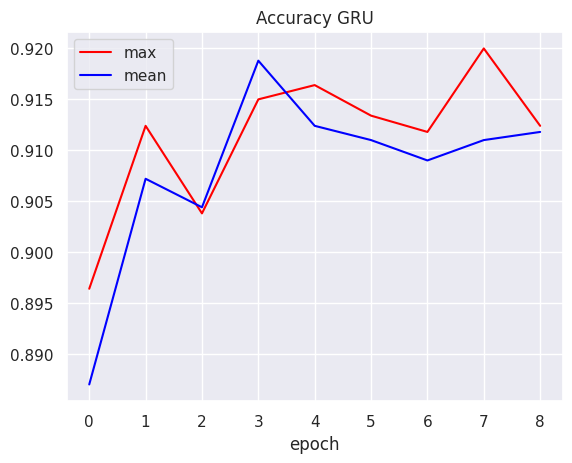

In [ ]:
for (name, values), color in zip(losses_type_GRU.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_GRU[name][1:])), acc_type_GRU[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_GRU[name]) * 100):.2f}")

plt.title('Accuracy GRU')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
test_predictions = []
test_target = []
with torch.no_grad():
    for batch in test_dataloader:
        model_GRU_max.eval()
        logits = model_GRU_max(batch['input_ids'])
        test_predictions.append(logits.argmax(dim=1))
        test_target.append(batch['label'])
test_predictions = torch.cat(test_predictions)
test_target = torch.cat(test_target)
test_accuracy_GRU_max = (test_predictions == test_target).float().mean().item()

print(f'test_accuracy_GRU_max = {np.around(test_accuracy_GRU_max, 3)}')

test_accuracy_GRU_max = 0.922


In [ ]:
test_predictions = []
test_target = []
with torch.no_grad():
    for batch in test_dataloader:
        model_GRU_mean.eval()
        logits = model_GRU_mean(batch['input_ids'])
        test_predictions.append(logits.argmax(dim=1))
        test_target.append(batch['label'])
test_predictions = torch.cat(test_predictions)
test_target = torch.cat(test_target)
test_accuracy_GRU_mean = (test_predictions == test_target).float().mean().item()

print(f'test_accuracy_GRU_mean = {np.around(test_accuracy_GRU_mean, 3)}')

test_accuracy_GRU_mean = 0.914


## ------------------------------ LSTM ----------------------------------

In [ ]:
class CharLM_LSTM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, embeding_len: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embeding_len)
        self.rnn = nn.LSTM(embeding_len, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type_LSTM = {}
acc_type_LSTM = {}

model_LSTM_max = CharLM_LSTM(hidden_dim=256, vocab_size=len(vocab), embeding_len=256, aggregation_type='max').to(device)
model_LSTM_mean = CharLM_LSTM(hidden_dim=256, vocab_size=len(vocab), embeding_len=256, aggregation_type='mean').to(device)

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_LSTM = CharLM_LSTM(
        hidden_dim=256, vocab_size=len(vocab), embeding_len=256, aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_LSTM.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_LSTM.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_LSTM(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_LSTM.eval()
                acc.append(evaluate(model_LSTM, eval_dataloader))
                model_LSTM.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_LSTM[aggregation_type] = losses
    acc_type_LSTM[aggregation_type] = acc

    if aggregation_type == 'max':
        model_LSTM_max = model_LSTM
    else:
        model_LSTM_mean = model_LSTM

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

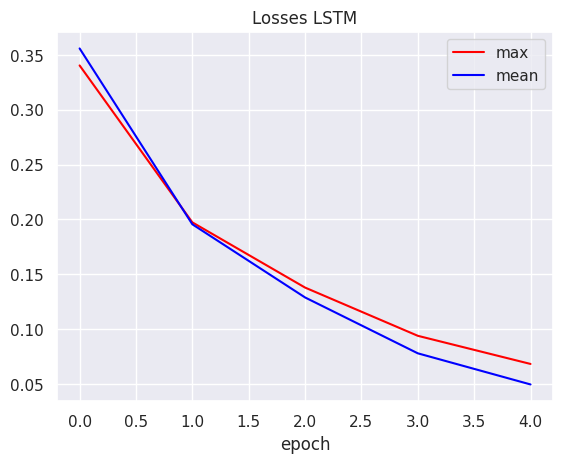

In [ ]:
for (name, values), color in zip(losses_type_LSTM.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_LSTM[name])), losses_type_LSTM[name], color=color, label=name)

plt.title('Losses LSTM')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.72
Лучшая accuracy для подхода mean: 92.44


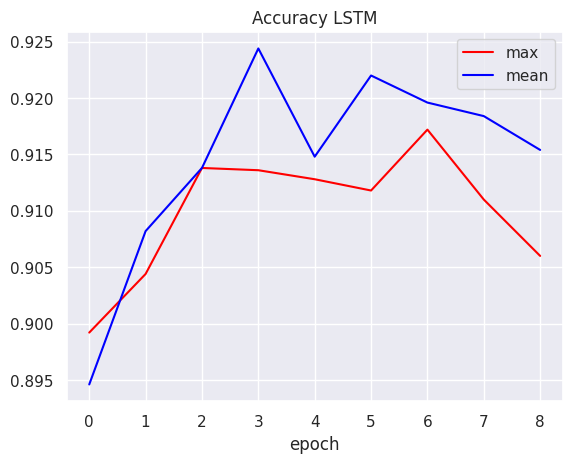

In [ ]:
for (name, values), color in zip(losses_type_LSTM.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_LSTM[name][1:])), acc_type_LSTM[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_LSTM[name]) * 100):.2f}")

plt.title('Accuracy LSTM')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
test_predictions = []
test_target = []
with torch.no_grad():
    for batch in test_dataloader:
        model_LSTM_max.eval()
        logits = model_LSTM_max(batch['input_ids'])
        test_predictions.append(logits.argmax(dim=1))
        test_target.append(batch['label'])
test_predictions = torch.cat(test_predictions)
test_target = torch.cat(test_target)
test_accuracy_LSTM_max = (test_predictions == test_target).float().mean().item()

print(f'test_accuracy_LSTM_max = {np.around(test_accuracy_LSTM_max, 3)}')

test_accuracy_LSTM_max = 0.918


In [ ]:
test_predictions = []
test_target = []
with torch.no_grad():
    for batch in test_dataloader:
        model_LSTM_mean.eval()
        logits = model_LSTM_mean(batch['input_ids'])
        test_predictions.append(logits.argmax(dim=1))
        test_target.append(batch['label'])
test_predictions = torch.cat(test_predictions)
test_target = torch.cat(test_target)
test_accuracy_LSTM_mean = (test_predictions == test_target).float().mean().item()

print(f'test_accuracy_LSTM_mean = {np.around(test_accuracy_LSTM_mean, 3)}')

test_accuracy_LSTM_mean = 0.919


## --------------------------- GRU mean agg N layers -----------------------------

In [ ]:
class CharLM_GRU_N_layers(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, embeding_len: int, num_classes: int = 4,
        aggregation_type: str = 'max', N_layers: int = 1
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embeding_len)
        self.rnn = nn.GRU(embeding_len, hidden_dim, num_layers=N_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type_GRU_Nl = {}
acc_type_GRU_Nl = {}

# for aggregation_type in ['max', 'mean']:
for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_GRU_Nl = CharLM_GRU_N_layers(
        hidden_dim=256, vocab_size=len(vocab), embeding_len=256, aggregation_type=aggregation_type, N_layers=3).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_GRU_Nl.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_GRU_Nl.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_GRU_Nl(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_GRU_Nl.eval()
                acc.append(evaluate(model_GRU_Nl, eval_dataloader))
                model_GRU_Nl.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_GRU_Nl[aggregation_type] = losses
    acc_type_GRU_Nl[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

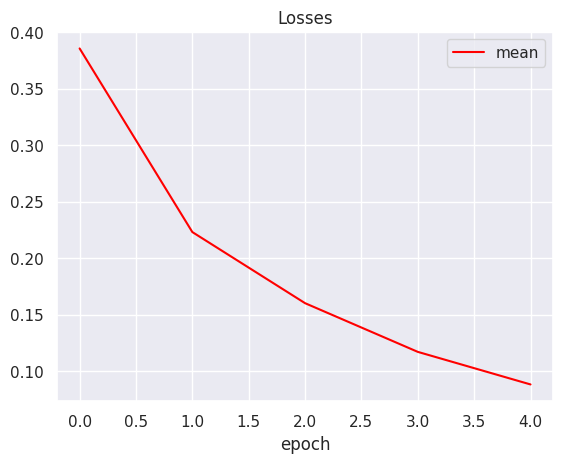

In [ ]:
for (name, values), color in zip(losses_type_GRU_Nl.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_GRU_Nl[name])), losses_type_GRU_Nl[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.92


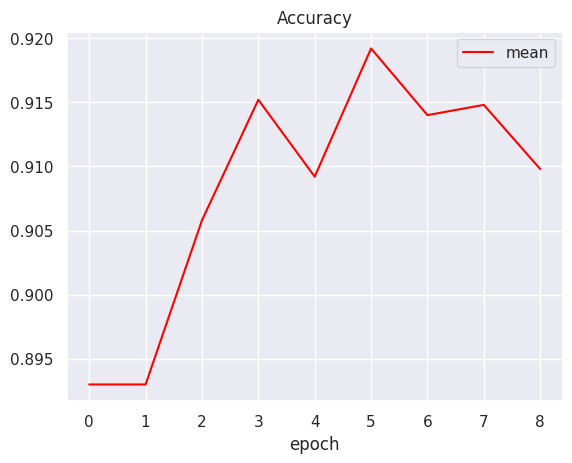

In [ ]:
for (name, values), color in zip(losses_type_GRU_Nl.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_GRU_Nl[name][1:])), acc_type_GRU_Nl[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_GRU_Nl[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
test_predictions = []
test_target = []
with torch.no_grad():
    for batch in test_dataloader:
        model_GRU_Nl.eval()
        logits = model_GRU_Nl(batch['input_ids'])
        test_predictions.append(logits.argmax(dim=1))
        test_target.append(batch['label'])
test_predictions = torch.cat(test_predictions)
test_target = torch.cat(test_target)
test_accuracy_GRU_Nl = (test_predictions == test_target).float().mean().item()

print(f'test_accuracy_GRU_Nl = {np.around(test_accuracy_GRU_Nl, 3)}')

test_accuracy_GRU_Nl = 0.919


## -------------------------------- LSTM mean agg N layers ---------------------------

In [48]:
class CharLM_LSTM_N_layers(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, embeding_len: int, num_classes: int = 4,
        aggregation_type: str = 'max', N_layers: int = 1
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embeding_len)
        self.rnn = nn.LSTM(embeding_len, hidden_dim, num_layers=N_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type_LSTM_Nl = {}
acc_type_LSTM_Nl = {}

# for aggregation_type in ['max', 'mean']:
for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_LSTM_Nl = CharLM_LSTM_N_layers(
        hidden_dim=256, vocab_size=len(vocab), embeding_len=256, aggregation_type=aggregation_type, N_layers=3).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_LSTM_Nl.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_LSTM_Nl.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_LSTM_Nl(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_LSTM_Nl.eval()
                acc.append(evaluate(model_LSTM_Nl, eval_dataloader))
                model_LSTM_Nl.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_LSTM_Nl[aggregation_type] = losses
    acc_type_LSTM_Nl[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

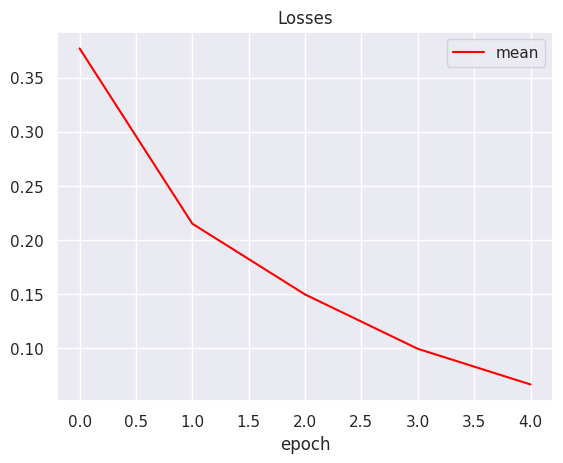

In [ ]:
for (name, values), color in zip(losses_type_LSTM_Nl.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_LSTM_Nl[name])), losses_type_LSTM_Nl[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.74


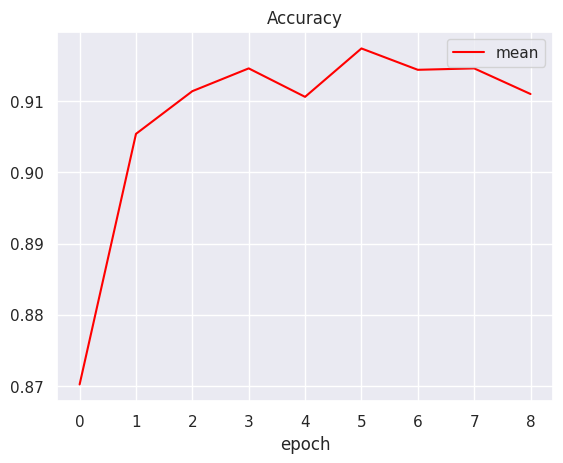

In [ ]:
for (name, values), color in zip(losses_type_LSTM_Nl.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_LSTM_Nl[name][1:])), acc_type_LSTM_Nl[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_LSTM_Nl[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
test_predictions = []
test_target = []
with torch.no_grad():
    for batch in test_dataloader:
        model_LSTM_Nl.eval()
        logits = model_LSTM_Nl(batch['input_ids'])
        test_predictions.append(logits.argmax(dim=1))
        test_target.append(batch['label'])
test_predictions = torch.cat(test_predictions)
test_target = torch.cat(test_target)
test_accuracy_LSTM_Nl = (test_predictions == test_target).float().mean().item()

print(f'test_accuracy_LSTM_Nl = {np.around(test_accuracy_LSTM_Nl, 3)}')

test_accuracy_LSTM_Nl = 0.921


# --------------------------- bidirectional GRU ---------------------------

In [29]:
class CharLM_GRU_bd(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, embeding_len: int, num_classes: int = 4,
        aggregation_type: str = 'max', N_layers: int = 1, dropout_rate: float = 0.1, bd: bool = False
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embeding_len)
        self.rnn = nn.GRU(embeding_len, hidden_dim, num_layers=N_layers, bidirectional=bd, batch_first=True)
        self.linear = nn.Linear(hidden_dim*2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, hidden = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim*2]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim*2]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim*2]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
%%time

num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type_GRU_bd = {}
acc_type_GRU_bd = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_GRU_bd = CharLM_GRU_bd(
        hidden_dim=256, vocab_size=len(vocab), embeding_len=256, N_layers=3, dropout_rate=0.1, bd=True, aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_GRU_bd.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_GRU_bd.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_GRU_bd(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_GRU_bd.eval()
                acc_now = evaluate(model_GRU_bd, eval_dataloader)
                acc.append(acc_now)
                model_GRU_bd.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_GRU_bd[aggregation_type] = losses
    acc_type_GRU_bd[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

CPU times: user 10min 48s, sys: 6.66 s, total: 10min 54s
Wall time: 11min 5s


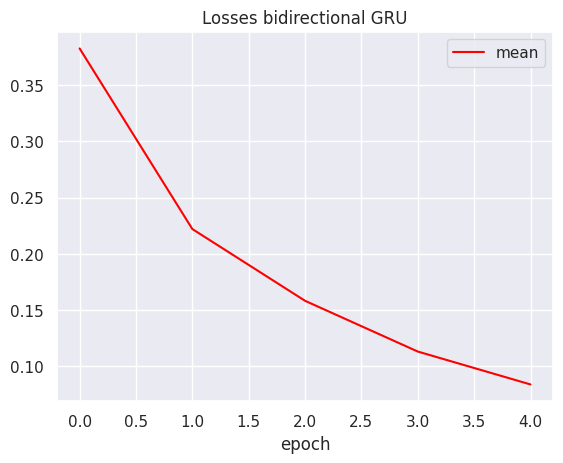

In [ ]:
for (name, values), color in zip(losses_type_GRU_bd.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_GRU_bd[name])), losses_type_GRU_bd[name], color=color, label=name)

plt.title('Losses bidirectional GRU')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.70


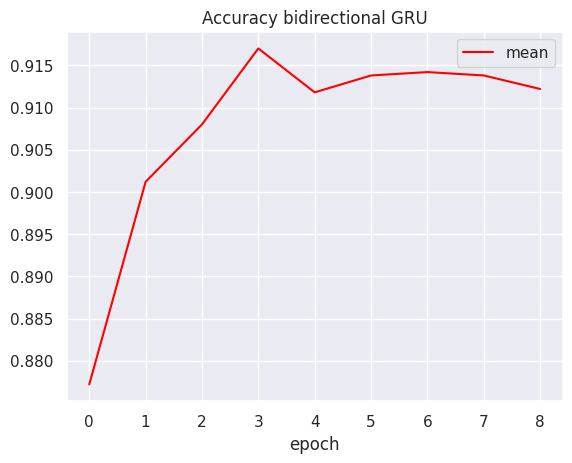

In [ ]:
for (name, values), color in zip(losses_type_GRU_bd.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_GRU_bd[name][1:])), acc_type_GRU_bd[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_GRU_bd[name]) * 100):.2f}")

plt.title('Accuracy bidirectional GRU')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
test_predictions = []
test_target = []
with torch.no_grad():
    for batch in test_dataloader:
        model_GRU_bd.eval()
        logits = model_GRU_bd(batch['input_ids'])
        test_predictions.append(logits.argmax(dim=1))
        test_target.append(batch['label'])
test_predictions = torch.cat(test_predictions)
test_target = torch.cat(test_target)
test_accuracy_GRU_bd = (test_predictions == test_target).float().mean().item()

print(f'test_accuracy_GRU_bd = {np.around(test_accuracy_GRU_bd, 3)}')

test_accuracy_GRU_bd = 0.92


# ------------------------- bidirectional LSTM ------------------------

In [ ]:
class CharLM_LSTM_bd(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, embeding_len: int, num_classes: int = 4,
        aggregation_type: str = 'max', N_layers: int = 1, dropout_rate: float = 0.1, bd: bool = False
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embeding_len)
        self.rnn = nn.LSTM(embeding_len, hidden_dim, num_layers=N_layers, bidirectional=bd, batch_first=True)
        self.linear = nn.Linear(hidden_dim*2, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, hidden = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim*2]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim*2]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim*2]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
%%time

num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type_LSTM_bd = {}
acc_type_LSTM_bd = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_LSTM_bd = CharLM_LSTM_bd(
        hidden_dim=256, vocab_size=len(vocab), embeding_len=256, N_layers=3, dropout_rate=0.1, bd=True, aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_LSTM_bd.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_LSTM_bd.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_LSTM_bd(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_LSTM_bd.eval()
                acc_now = evaluate(model_LSTM_bd, eval_dataloader)
                acc.append(acc_now)
                model_LSTM_bd.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_LSTM_bd[aggregation_type] = losses
    acc_type_LSTM_bd[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

CPU times: user 11min 57s, sys: 7.51 s, total: 12min 4s
Wall time: 12min 32s


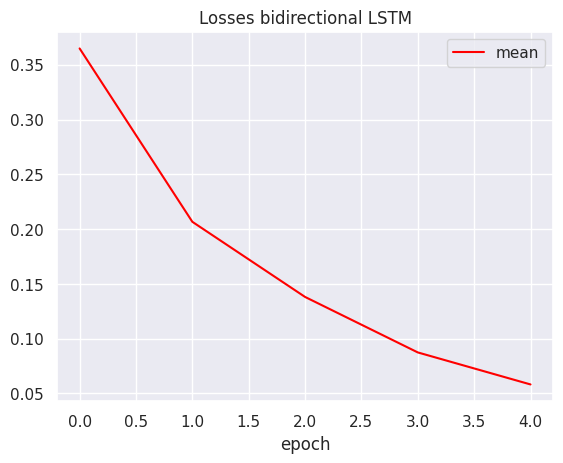

In [ ]:
for (name, values), color in zip(losses_type_LSTM_bd.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_LSTM_bd[name])), losses_type_LSTM_bd[name], color=color, label=name)

plt.title('Losses bidirectional LSTM')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 92.16


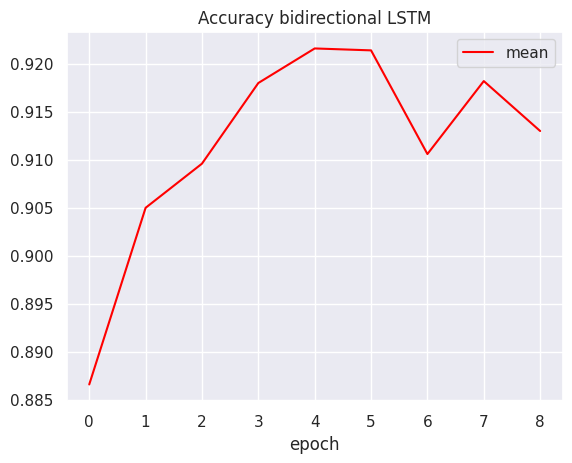

In [ ]:
for (name, values), color in zip(losses_type_LSTM_bd.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_LSTM_bd[name][1:])), acc_type_LSTM_bd[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_LSTM_bd[name]) * 100):.2f}")

plt.title('Accuracy bidirectional LSTM')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
test_predictions = []
test_target = []
with torch.no_grad():
    for batch in test_dataloader:
        model_LSTM_bd.eval()
        logits = model_LSTM_bd(batch['input_ids'])
        test_predictions.append(logits.argmax(dim=1))
        test_target.append(batch['label'])
test_predictions = torch.cat(test_predictions)
test_target = torch.cat(test_target)
test_accuracy_LSTM_bd = (test_predictions == test_target).float().mean().item()

print(f'test_accuracy_LSTM_bd = {np.around(test_accuracy_LSTM_bd, 3)}')

test_accuracy_LSTM_bd = 0.917


### Попробуем уменьшить размер эмбединга с 256 до 64 для 3-слойной bidirectional GRU

In [30]:
%%time

num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type_GRU_bd_64 = {}
acc_type_GRU_bd_64 = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_GRU_bd_64 = CharLM_GRU_bd(
        hidden_dim=256, vocab_size=len(vocab), embeding_len=64, N_layers=3, dropout_rate=0.1, bd=True, aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_GRU_bd_64.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_GRU_bd_64.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_GRU_bd_64(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_GRU_bd_64.eval()
                acc_now = evaluate(model_GRU_bd_64, eval_dataloader)
                acc.append(acc_now)
                model_GRU_bd_64.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_GRU_bd_64[aggregation_type] = losses
    acc_type_GRU_bd_64[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

CPU times: user 10min 47s, sys: 6.84 s, total: 10min 53s
Wall time: 11min 52s


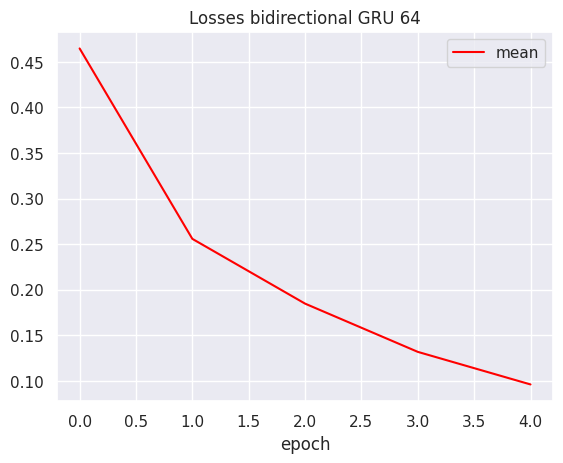

In [31]:
for (name, values), color in zip(losses_type_GRU_bd_64.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_GRU_bd_64[name])), losses_type_GRU_bd_64[name], color=color, label=name)

plt.title('Losses bidirectional GRU 64')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.12


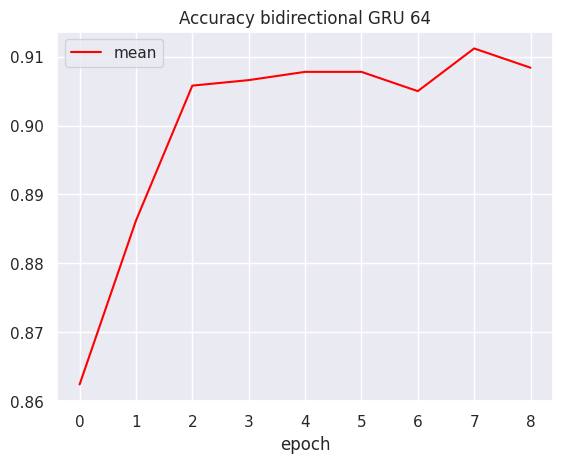

In [32]:
for (name, values), color in zip(losses_type_GRU_bd_64.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_GRU_bd_64[name][1:])), acc_type_GRU_bd_64[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_GRU_bd_64[name]) * 100):.2f}")

plt.title('Accuracy bidirectional GRU 64')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [33]:
test_predictions = []
test_target = []
with torch.no_grad():
    for batch in test_dataloader:
        model_GRU_bd_64.eval()
        logits = model_GRU_bd_64(batch['input_ids'])
        test_predictions.append(logits.argmax(dim=1))
        test_target.append(batch['label'])
test_predictions = torch.cat(test_predictions)
test_target = torch.cat(test_target)
test_accuracy_GRU_bd_64 = (test_predictions == test_target).float().mean().item()

print(f'test_accuracy_GRU_bd_64 = {np.around(test_accuracy_GRU_bd_64, 3)}')

test_accuracy_GRU_bd_64 = 0.911


### Слегка увеличим дропаут с 0.1 до 0.3

In [43]:
%%time

num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type_GRU_bd_do03 = {}
acc_type_GRU_bd_do03 = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_GRU_bd_do03 = CharLM_GRU_bd(
        hidden_dim=256, vocab_size=len(vocab), embeding_len=256, N_layers=3, dropout_rate=0.3, bd=True, aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_GRU_bd_do03.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_GRU_bd_do03.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_GRU_bd_do03(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_GRU_bd_do03.eval()
                acc_now = evaluate(model_GRU_bd_do03, eval_dataloader)
                acc.append(acc_now)
                model_GRU_bd_do03.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_GRU_bd_do03[aggregation_type] = losses
    acc_type_GRU_bd_do03[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

CPU times: user 11min 8s, sys: 7.23 s, total: 11min 15s
Wall time: 11min 32s


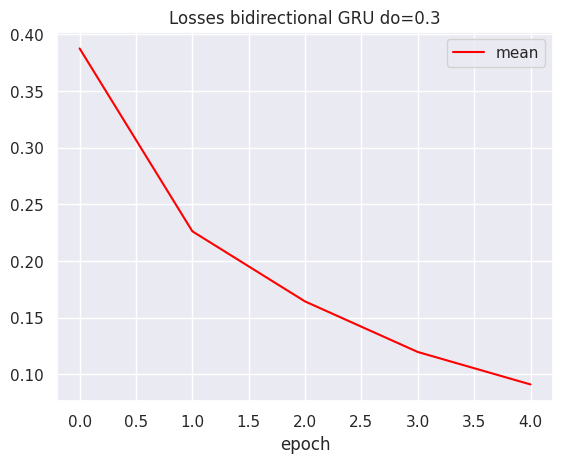

In [44]:
for (name, values), color in zip(losses_type_GRU_bd_do03.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_GRU_bd_do03[name])), losses_type_GRU_bd_do03[name], color=color, label=name)

plt.title('Losses bidirectional GRU do=0.3')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.34


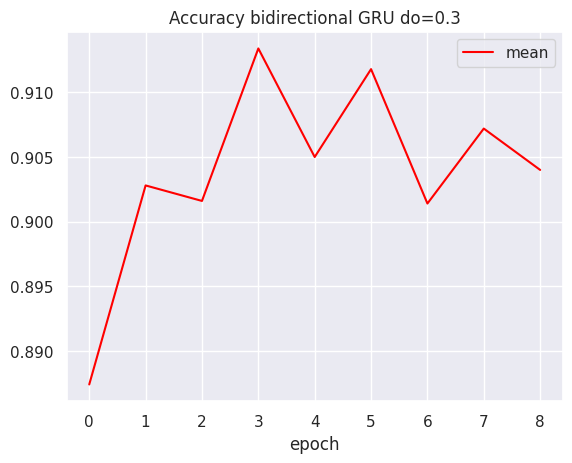

In [45]:
for (name, values), color in zip(losses_type_GRU_bd_do03.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_GRU_bd_do03[name][1:])), acc_type_GRU_bd_do03[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_GRU_bd_do03[name]) * 100):.2f}")

plt.title('Accuracy bidirectional GRU do=0.3')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [46]:
test_predictions = []
test_target = []
with torch.no_grad():
    for batch in test_dataloader:
        model_GRU_bd_do03.eval()
        logits = model_GRU_bd_do03(batch['input_ids'])
        test_predictions.append(logits.argmax(dim=1))
        test_target.append(batch['label'])
test_predictions = torch.cat(test_predictions)
test_target = torch.cat(test_target)
test_accuracy_GRU_bd_do03 = (test_predictions == test_target).float().mean().item()

print(f'test_accuracy_GRU_bd_do03 = {np.around(test_accuracy_GRU_bd_do03, 3)}')

test_accuracy_GRU_bd_do03 = 0.917


Увеличим количество линейных слоев

In [38]:
class CharLM_GRU_bd_3lin(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, embeding_len: int, num_classes: int = 4,
        aggregation_type: str = 'max', N_layers: int = 1, dropout_rate: float = 0.1, bd: bool = False
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embeding_len)
        self.rnn = nn.GRU(embeding_len, hidden_dim, num_layers=N_layers, bidirectional=bd, batch_first=True)
        self.linear = nn.Linear(hidden_dim*2, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, hidden = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim*2]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim*2]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim*2]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        output = self.dropout(self.linear2(self.non_lin(output)))  # [batch_size, hidden_dim]
        output = self.dropout(self.linear3(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [39]:
%%time

num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type_GRU_bd_3lin = {}
acc_type_GRU_bd_3lin = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_GRU_bd_3lin = CharLM_GRU_bd_3lin(
        hidden_dim=256, vocab_size=len(vocab), embeding_len=256, N_layers=3, dropout_rate=0.1, bd=True, aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_GRU_bd_3lin.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_GRU_bd_3lin.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_GRU_bd_3lin(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_GRU_bd_3lin.eval()
                acc_now = evaluate(model_GRU_bd_3lin, eval_dataloader)
                acc.append(acc_now)
                model_GRU_bd_3lin.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_GRU_bd_3lin[aggregation_type] = losses
    acc_type_GRU_bd_3lin[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

CPU times: user 11min 1s, sys: 7.07 s, total: 11min 8s
Wall time: 11min 18s


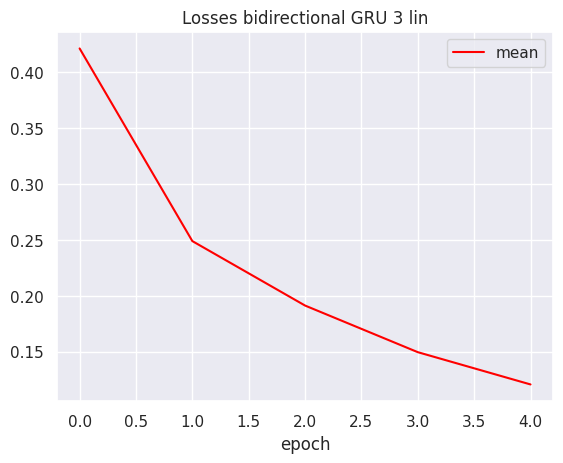

In [40]:
for (name, values), color in zip(losses_type_GRU_bd_3lin.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_GRU_bd_3lin[name])), losses_type_GRU_bd_3lin[name], color=color, label=name)

plt.title('Losses bidirectional GRU 3 lin')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.60


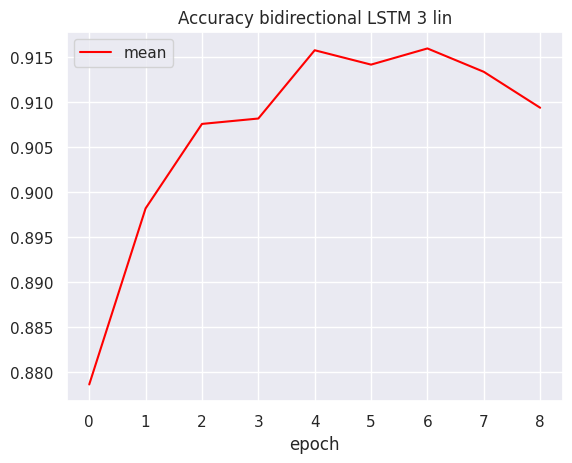

In [41]:
for (name, values), color in zip(losses_type_GRU_bd_3lin.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_GRU_bd_3lin[name][1:])), acc_type_GRU_bd_3lin[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_GRU_bd_3lin[name]) * 100):.2f}")

plt.title('Accuracy bidirectional LSTM 3 lin')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [42]:
test_predictions = []
test_target = []
with torch.no_grad():
    for batch in test_dataloader:
        model_GRU_bd_3lin.eval()
        logits = model_GRU_bd_3lin(batch['input_ids'])
        test_predictions.append(logits.argmax(dim=1))
        test_target.append(batch['label'])
test_predictions = torch.cat(test_predictions)
test_target = torch.cat(test_target)
test_accuracy_GRU_bd_3lin = (test_predictions == test_target).float().mean().item()

print(f'test_accuracy_GRU_bd_3lin = {np.around(test_accuracy_GRU_bd_3lin, 3)}')

test_accuracy_GRU_bd_3lin = 0.914


In [49]:
num_epoch = 10
eval_steps = len(train_dataloader) // 2


losses_type_LSTM_Nl = {}
acc_type_LSTM_Nl = {}

# for aggregation_type in ['max', 'mean']:
for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_LSTM_Nl = CharLM_LSTM_N_layers(
        hidden_dim=256, vocab_size=len(vocab), embeding_len=256, aggregation_type=aggregation_type, N_layers=3).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_LSTM_Nl.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_LSTM_Nl.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_LSTM_Nl(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_LSTM_Nl.eval()
                acc.append(evaluate(model_LSTM_Nl, eval_dataloader))
                model_LSTM_Nl.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type_LSTM_Nl[aggregation_type] = losses
    acc_type_LSTM_Nl[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

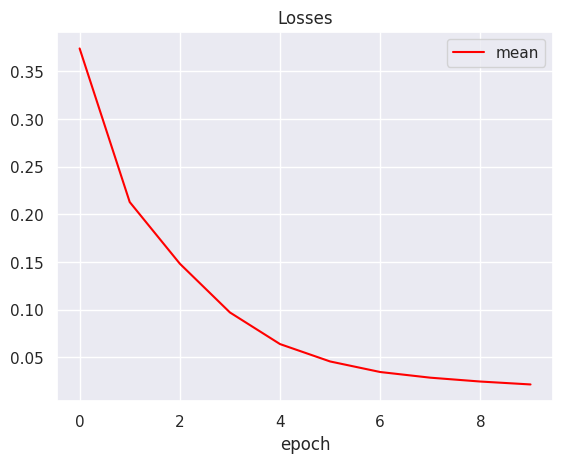

In [50]:
for (name, values), color in zip(losses_type_LSTM_Nl.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type_LSTM_Nl[name])), losses_type_LSTM_Nl[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.54


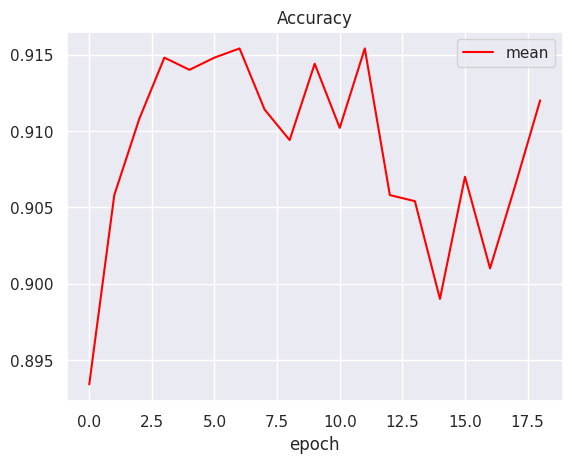

In [51]:
for (name, values), color in zip(losses_type_LSTM_Nl.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type_LSTM_Nl[name][1:])), acc_type_LSTM_Nl[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type_LSTM_Nl[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [52]:
test_predictions = []
test_target = []
with torch.no_grad():
    for batch in test_dataloader:
        model_LSTM_Nl.eval()
        logits = model_LSTM_Nl(batch['input_ids'])
        test_predictions.append(logits.argmax(dim=1))
        test_target.append(batch['label'])
test_predictions = torch.cat(test_predictions)
test_target = torch.cat(test_target)
test_accuracy_LSTM_Nl = (test_predictions == test_target).float().mean().item()

print(f'test_accuracy_LSTM_Nl = {np.around(test_accuracy_LSTM_Nl, 3)}')

test_accuracy_LSTM_Nl = 0.913


# ---------------------------------- Отчет ----------------------------------


В первую очередь была изменена базовая предобработка текста:
 - Знаки препинания были не удалены, а заменены на пробелы, что на первый взгляд улучшило качество токенизации
 - Также был заменен порог на минимальное количество вхождений одного слова counter_threshold с 25 на 10, что не удлиннило время обучения.

Базовая модель сразу же показала неплохие результаты на тестовой выборке:
 - accuracy = 0.909 для max агрегации
 - accuracy = 0.913 для mean агрегации

Замена nn.rnn на nn.GRU дала следующие метрики на тестовой выборке:
 - accuracy = 0.922 для max агрегации
 - accuracy = 0.914 для mean агрегации

Замена nn.rnn на nn.LSTM дала следующие метрики на тестовой выборке:
 - accuracy = 0.918 для max агрегации
 - accuracy = 0.919 для mean агрегации

Далее я рассматривал только mean агрегацию и последовательно пробовал менять различные параметры для архитектру с GRU и LSTM
- Увеличение количества слоев рекурентной сети с 1 до 3 дало следующие результаты:
 - accuracy = 0.919 для GRU
 - accuracy = 0.921 для LSTM
- Далее я решил оставить 3 слоя и попробовал включить bidirectional режим, что дало следующие результаты:
 - accuracy = 0.920 для GRU
 - accuracy = 0.917 для LSTM

Далее я экспериментировал с bidirectional GRU с 3 слоями:
 - Уменьшение размера эмбединга с 256 до 64 показывает более монотонный рост accuracy в зависимости от эпохи, но этоговый результат хуже чем раньше: accuracy = 0.911
 - Также я попробовал увеличить вероятность дропаута с 0.1 до 0.3, что также не привело к улучшению целевой метрики: accuracy = 0.917
 - Увеличение fully conected линейных слоев с 1 до 3 также не улучшило метрику: accuracy = 0.914


В конце я взял LSTM с 3 рекурентными слоями (она показывала метрику accuracy = 0.921) и увеличил количество эпох с 5 до 10, что в итоге также привело к ухудшению метрики.

Итог:
Наилучшая архитектура это GRU или LSTM с тремя рекурентными слоями и остальными параметрами по дефолту.
Можно было бы еще отдельно поэкспериментировать с max агрегацией, а также предобработкой текста (например лематизация в перспективе могла бы улучшить качетсво классификации), но я и так уже опоздал на мягкий дедлайн и получил заветную accuracy >= 0.915 для нескольких конфигураций.